# NAME: Poli Vamsi Vardhan Reddy.                            Job Code - EMTI000AIML

# Project Title: Automated Brain Tumor Segmentation and Analysis

## 1. Introduction
- *Objective*: To Develop an automated AI-based framework for brain tumor segmentation using deep learning.
- *Significance*: Early and accurate detection of brain tumors is crucial for diagnosis and treatment planning.
- *Approach*: Utilized deep learning models (U-Net with Attention Mechanisms) and MONAI for neuroimaging analysis.

## 2. Dataset Overview
- *Dataset Name*: BraTS 2020 (Brain Tumor Segmentation Challenge)
- *Data Format*: NIfTI (.nii) medical imaging files.
- *Types of MRI Modalities*:
  - FLAIR (Fluid Attenuated Inversion Recovery)
  - T1-weighted MRI
  - T1ce (T1-weighted with contrast enhancement)
  - T2-weighted MRI
  - Segmentation Mask (Ground truth labels)
- *Classes in Segmentation Mask*:
  - 0: No tumor
  - 1: Necrotic/core tumor
  - 2: Edema
  - 3: Enhancing tumor

## 3. Data Preprocessing
- *Loading Data*: Used nibabel to load NIfTI files.
- *Normalization*: Scaled pixel intensity values for uniformity.
- *Augmentation*: Applied transformations (rotation, flipping, scaling) to improve model generalization.
- *Resizing*: Standardize image size for model input.

## 4. Data Visualization
- *MRI Slices Visualization*: Ploted different slices of MRI images.
- *Segmentation Mask Overlay*: Displayed tumor masks overlayed on the images.
- *3D Rendering*: Generated 3D volume representations of the brain scan.

## 5. Model Development
- *Model Architecture*: Modified U-Net with Attention Gates for segmentation.
- *Loss Function*: Categorical Cross-Entropy.
- *Evaluation Metrics*:
  - Dice Coefficient
  - Precision
  - Sensitivity (Recall)
  - Specificity
- *Training Strategy*: Use MONAI's data pipeline for efficient training.

## 6. Training and Validation
- *Splitting Data*: Train (70%), Validation (20%), Test (10%).
- *Training Pipeline*:
  - Used MONAI for dataset loading and augmentation.
  - Trained using TensorFlow/Keras.
  - Used callbacks (EarlyStopping, ReduceLROnPlateau, ModelCheckpoint).

## 7. Performance Evaluation
- *Metrics Computation*: Dice Score, Precision, Recall, Specificity,Train Accuracy,Validation loss.

## 8. Model Inference and Deployment
- *Inference Pipeline*: Tested the trained model on new MRI scans.
- *Visualization*: Displayed predictions with segmentation masks.




In [1]:
import os
import cv2
import glob
import PIL
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage 
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
from PIL import Image, ImageOps  

# neural imaging
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt
import nilearn.image as nlimg

# ml libs
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, Dropout
from tensorflow.keras.models import Model
# MONAI components
from monai.data import Dataset, DataLoader
from monai.transforms import Compose, LoadImaged, EnsureChannelFirstd, ScaleIntensityd, ToTensord,ScaleIntensityd

import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
TRAIN_DATASET_PATH = '../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'

In [3]:
np.set_printoptions(precision=3, suppress=True)
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE',
    2 : 'EDEMA',
    3 : 'ENHANCING' 
}

VOLUME_SLICES = 100 
VOLUME_START_AT = 22

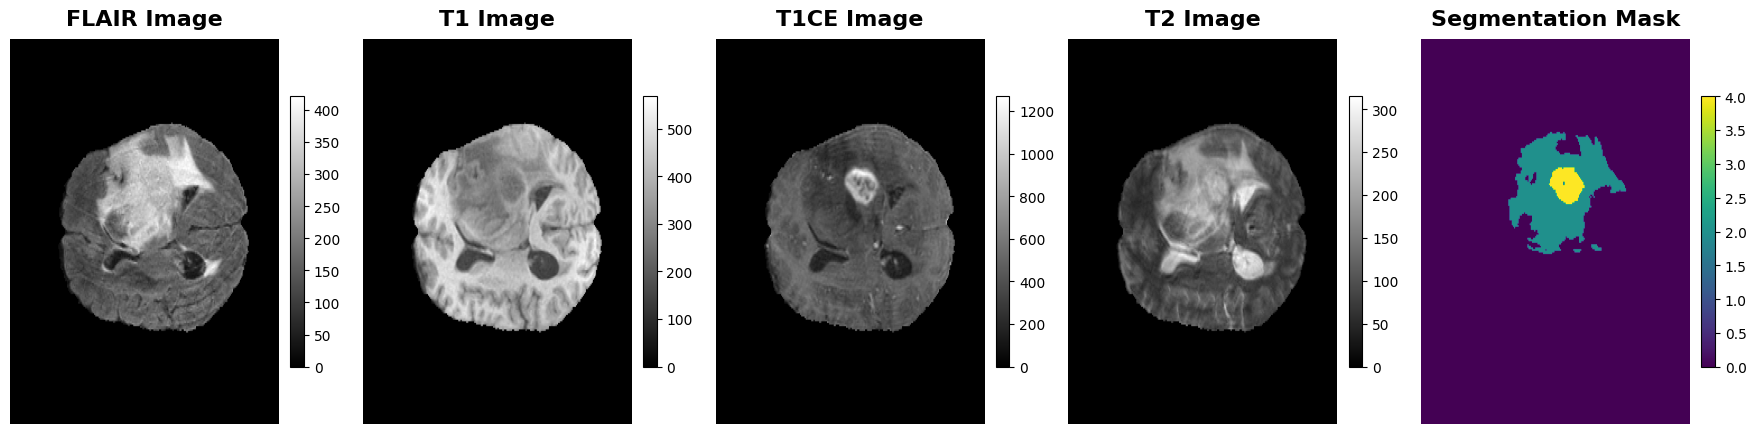

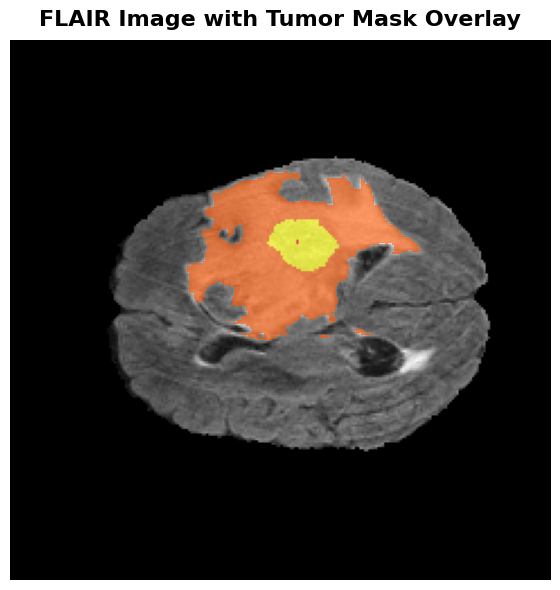

In [4]:
# Load images and mask
test_image_flair = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_flair.nii').get_fdata()
test_image_t1 = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t1.nii').get_fdata()
test_image_t1ce = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t1ce.nii').get_fdata()
test_image_t2 = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t2.nii').get_fdata()
test_mask = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_seg.nii').get_fdata()

# Slice index (choosing a middle slice in the axial plane)
slice_idx = test_image_flair.shape[2] // 2  

# Plotting images with headings
fig, axs = plt.subplots(1, 5, figsize=(22, 5), gridspec_kw={'wspace': 0.2})  

# Titles for images
titles = ['FLAIR Image', 'T1 Image', 'T1CE Image', 'T2 Image', 'Segmentation Mask']
modalities = [test_image_flair, test_image_t1, test_image_t1ce, test_image_t2, test_mask]
cmaps = ['gray', 'gray', 'gray', 'gray', 'viridis']

# Display each modality
for i, (img, title, cmap) in enumerate(zip(modalities, titles, cmaps)):
    ax = axs[i]
    im = ax.imshow(img[:, :, slice_idx], cmap=cmap, aspect='auto')
    ax.set_title(title, fontsize=16, weight='bold', pad=10)  # Added padding for better separation
    ax.axis('off')
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

# Overlay mask on FLAIR for better visualization
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(test_image_flair[:, :, slice_idx], cmap='gray')
ax.imshow(np.ma.masked_where(test_mask[:, :, slice_idx] == 0, test_mask[:, :, slice_idx]), 
          cmap='autumn', alpha=0.6)
ax.set_title("FLAIR Image with Tumor Mask Overlay", fontsize=16, weight='bold', pad=10)
ax.axis('off')

plt.tight_layout()
plt.show()


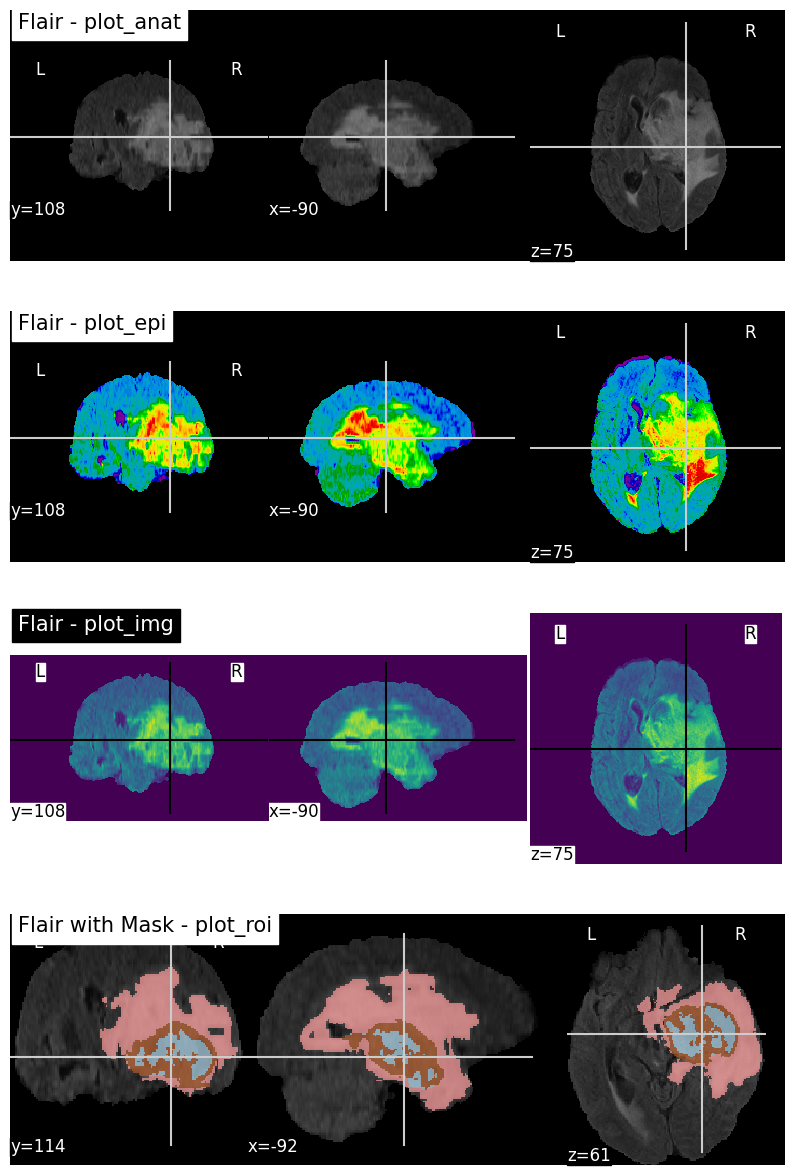

In [5]:

# Correctly construct file paths
SAMPLE_CASE = "BraTS20_Training_001"
FLAIR_PATH = os.path.join(TRAIN_DATASET_PATH, SAMPLE_CASE, f"{SAMPLE_CASE}_flair.nii")
MASK_PATH = os.path.join(TRAIN_DATASET_PATH, SAMPLE_CASE, f"{SAMPLE_CASE}_seg.nii")

# Load images
niimg = nlimg.load_img(FLAIR_PATH)
nimask = nlimg.load_img(MASK_PATH)

fig, axes = plt.subplots(nrows=4, figsize=(10, 15))  


nlplt.plot_anat(niimg, title="Flair - plot_anat", axes=axes[0])
nlplt.plot_epi(niimg, title="Flair - plot_epi", axes=axes[1])
nlplt.plot_img(niimg, title="Flair - plot_img", axes=axes[2])
nlplt.plot_roi(nimask, title="Flair with Mask - plot_roi", bg_img=niimg, axes=axes[3], cmap="Paired")

plt.show()

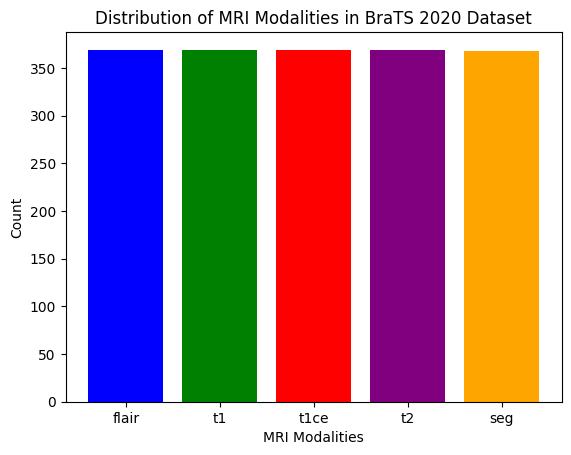

Modality Counts: {'flair': 369, 't1': 369, 't1ce': 369, 't2': 369, 'seg': 368}


In [6]:
# Define modalities to track separately
modalities = ["flair", "t1", "t1ce", "t2", "seg"]
modality_counts = {mod: 0 for mod in modalities}

# Count files for each modality
for case in os.listdir(TRAIN_DATASET_PATH):
    case_path = os.path.join(TRAIN_DATASET_PATH, case)
    if os.path.isdir(case_path):  # Ensure it's a directory (patient case)
        for file in os.listdir(case_path):
            for mod in modalities:
                if file.endswith(f"{mod}.nii"):
                    modality_counts[mod] += 1

# Plot the distribution
plt.bar(modality_counts.keys(), modality_counts.values(), color=['blue', 'green', 'red', 'purple', 'orange'])
plt.xlabel("MRI Modalities")
plt.ylabel("Count")
plt.title("Distribution of MRI Modalities in BraTS 2020 Dataset")
plt.show()

# Print counts
print(f"Modality Counts: {modality_counts}")


In [7]:
# General Dice Coefficient
def dice_coef(y_true, y_pred, smooth=1e-6):
    class_num = y_true.shape[-1]  # Number of classes in the prediction

    # Initialize total Dice coefficient
    total_dice = 0.0

    for i in range(class_num):
        # Flatten the tensors for each class
        y_true_f = tf.keras.layers.Flatten()(y_true[..., i])
        y_pred_f = tf.keras.layers.Flatten()(y_pred[..., i])

        # Cast tensors to float32
        y_true_f = tf.cast(y_true_f, tf.float32)
        y_pred_f = tf.cast(y_pred_f, tf.float32)

        # Compute intersection and union
        intersection = tf.reduce_sum(y_true_f * y_pred_f)
        union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)

        # Dice coefficient for current class
        dice = (2. * intersection + smooth) / (union + smooth)

        # Accumulate the Dice score
        total_dice += dice

    # Return average Dice coefficient across all classes
    return total_dice / class_num

# Dice Coefficients for specific tumor types (necrotic, edema, enhancing)
def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    y_true_f = K.cast(y_true, 'float32')
    y_pred_f = K.cast(y_pred, 'float32')
    
    intersection = K.sum(y_true_f[:, :, :, 1] * y_pred_f[:, :, :, 1])
    return (2. * intersection + epsilon) / (K.sum(y_true_f[:, :, :, 1]) + K.sum(y_pred_f[:, :, :, 1]) + epsilon)

# Dice Coefficient for edema tumor
def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    y_true_f = K.cast(y_true, 'float32')
    y_pred_f = K.cast(y_pred, 'float32')
    
    intersection = K.sum(y_true_f[:, :, :, 2] * y_pred_f[:, :, :, 2])
    return (2. * intersection + epsilon) / (K.sum(y_true_f[:, :, :, 2]) + K.sum(y_pred_f[:, :, :, 2]) + epsilon)

# Dice Coefficient for enhancing tumor
def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    y_true_f = K.cast(y_true, 'float32')
    y_pred_f = K.cast(y_pred, 'float32')
    
    intersection = K.sum(y_true_f[:, :, :, 3] * y_pred_f[:, :, :, 3])
    return (2. * intersection + epsilon) / (K.sum(y_true_f[:, :, :, 3]) + K.sum(y_pred_f[:, :, :, 3]) + epsilon)
# Precision metric
def precision(y_true, y_pred):
    y_true_f = K.cast(K.flatten(y_true), 'float32')
    y_pred_f = K.cast(K.flatten(y_pred), 'float32')
    
    true_positives = K.sum(K.round(K.clip(y_true_f * y_pred_f, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred_f, 0, 1)))
    
    return true_positives / (predicted_positives + K.epsilon())

# Sensitivity (Recall) metric
def sensitivity(y_true, y_pred):
    y_true_f = K.cast(K.flatten(y_true), 'float32')
    y_pred_f = K.cast(K.flatten(y_pred), 'float32')
    
    true_positives = K.sum(K.round(K.clip(y_true_f * y_pred_f, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true_f, 0, 1)))
    
    return true_positives / (possible_positives + K.epsilon())

# Specificity metric
def specificity(y_true, y_pred):
    y_true_f = K.cast(K.flatten(y_true), 'float32')
    y_pred_f = K.cast(K.flatten(y_pred), 'float32')
    
    true_negatives = K.sum(K.round(K.clip((1 - y_true_f) * (1 - y_pred_f), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true_f, 0, 1)))
    
    return true_negatives / (possible_negatives + K.epsilon())


In [8]:
def attention_gate(skip_connection, gating_signal, inter_channels):
    """Attention gate mechanism for focus on relevant features"""
    theta_x = Conv2D(inter_channels, (1, 1), strides=1, padding='same')(skip_connection)
    phi_g = Conv2D(inter_channels, (1, 1), strides=1, padding='same')(gating_signal)
    add_xg = Add()([theta_x, phi_g])
    act_xg = Activation('relu')(add_xg)
    psi = Conv2D(1, (1, 1), strides=1, padding='same')(act_xg)
    sigmoid_xg = Activation('sigmoid')(psi)
    attended_skip = Multiply()([skip_connection, sigmoid_xg])
    return attended_skip

def build_attention_unet(inputs, ker_init, dropout):
    """Modified U-Net with attention gates"""
    # Encoder
    conv1 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(inputs)
    conv1 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv1)
    pool = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(pool)
    conv = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv)
    
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init)(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=ker_init)(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv3)
    
    # Bottleneck
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv5 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer=ker_init)(pool4)
    conv5 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv5)
    drop5 = Dropout(dropout)(conv5)
    
    # Decoder with attention gates
    up7 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer=ker_init)(UpSampling2D(size=(2,2))(drop5))
    att_conv3 = attention_gate(conv3, up7, 128)
    merge7 = concatenate([att_conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=ker_init)(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv7)
    
    up8 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer=ker_init)(UpSampling2D(size=(2,2))(conv7))
    att_conv2 = attention_gate(conv2, up8, 64)
    merge8 = concatenate([att_conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init)(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv8)
    
    up9 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer=ker_init)(UpSampling2D(size=(2,2))(conv8))
    att_conv = attention_gate(conv, up9, 32)
    merge9 = concatenate([att_conv, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv9)
    
    up = Conv2D(32, 2, activation='relu', padding='same', kernel_initializer=ker_init)(UpSampling2D(size=(2,2))(conv9))
    att_conv1 = attention_gate(conv1, up, 16)
    merge = concatenate([att_conv1, up], axis=3)
    conv = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(merge)
    conv = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv)
    
    conv10 = Conv2D(4, (1,1), activation='softmax')(conv)
    
    return Model(inputs=inputs, outputs=conv10)

IMG_SIZE = 128
input_layer = Input((IMG_SIZE, IMG_SIZE, 4))
model = build_attention_unet(input_layer, 'he_normal', 0.2)
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema ,dice_coef_enhancing] )


In [9]:
from monai.transforms import Compose, LoadImaged, EnsureChannelFirstd, ScaleIntensityd, ToTensord

train_transforms = Compose([
    LoadImaged(keys=['image', 'label']),  
    EnsureChannelFirstd(keys=['image', 'label']), 
    ScaleIntensityd(keys=['image']),
    ToTensord(keys=['image', 'label'])
])


In [10]:
from sklearn.model_selection import train_test_split
# Lists of directories with studies
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]

# Remove the directory with the ill-formatted name
ill_formatted_dir = os.path.join(TRAIN_DATASET_PATH, 'BraTS20_Training_355')
if ill_formatted_dir in train_and_val_directories:
    train_and_val_directories.remove(ill_formatted_dir)

def pathListIntoIds(dir_list):
    return [os.path.basename(d) for d in dir_list]

train_and_test_ids = pathListIntoIds(train_and_val_directories)

# Split into training and validation
train_test_ids, val_ids = train_test_split(train_and_test_ids, test_size=0.2)

# Split the training set into training and testing
train_ids, test_ids = train_test_split(train_test_ids, test_size=0.15)

print(f"Training IDs: {train_ids}")
print(f"Validation IDs: {val_ids}")
print(f"Test IDs: {test_ids}")


Training IDs: ['BraTS20_Training_147', 'BraTS20_Training_158', 'BraTS20_Training_268', 'BraTS20_Training_042', 'BraTS20_Training_135', 'BraTS20_Training_014', 'BraTS20_Training_246', 'BraTS20_Training_253', 'BraTS20_Training_107', 'BraTS20_Training_154', 'BraTS20_Training_241', 'BraTS20_Training_361', 'BraTS20_Training_120', 'BraTS20_Training_187', 'BraTS20_Training_035', 'BraTS20_Training_331', 'BraTS20_Training_112', 'BraTS20_Training_184', 'BraTS20_Training_307', 'BraTS20_Training_189', 'BraTS20_Training_006', 'BraTS20_Training_303', 'BraTS20_Training_351', 'BraTS20_Training_338', 'BraTS20_Training_308', 'BraTS20_Training_296', 'BraTS20_Training_299', 'BraTS20_Training_143', 'BraTS20_Training_322', 'BraTS20_Training_222', 'BraTS20_Training_193', 'BraTS20_Training_174', 'BraTS20_Training_122', 'BraTS20_Training_218', 'BraTS20_Training_201', 'BraTS20_Training_324', 'BraTS20_Training_352', 'BraTS20_Training_227', 'BraTS20_Training_052', 'BraTS20_Training_284', 'BraTS20_Training_259', '

In [11]:
import numpy as np
import os
import cv2
import nibabel as nib
import tensorflow as tf
from tensorflow.keras.utils import Sequence

class DataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE, IMG_SIZE), batch_size=1, n_channels=4, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples'  # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.zeros((self.batch_size * VOLUME_SLICES, *self.dim, self.n_channels))
        Y = np.zeros((self.batch_size * VOLUME_SLICES, *self.dim, 4))

        # Generate data
        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(TRAIN_DATASET_PATH, i)

            try:
                # Load volumes
                flair = nib.load(os.path.join(case_path, f'{i}_flair.nii')).get_fdata()
                ce = nib.load(os.path.join(case_path, f'{i}_t1ce.nii')).get_fdata()
                seg = nib.load(os.path.join(case_path, f'{i}_seg.nii')).get_fdata()

                # Process slices
                for j in range(VOLUME_SLICES):
                    # Ensure slice index is within range
                    if j + VOLUME_START_AT >= flair.shape[2] or j + VOLUME_START_AT >= ce.shape[2]:
                        continue
                    
                    # Normalizing and resizing
                    X[j + VOLUME_SLICES * c, :, :, 0] = cv2.resize(flair[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
                    X[j + VOLUME_SLICES * c, :, :, 1] = cv2.resize(ce[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

                    # Prepare masks
                    y_slice = seg[:, :, j + VOLUME_START_AT]
                    y_slice = np.where(y_slice == 4, 3, y_slice)  # Convert 4 to 3
                    mask = tf.one_hot(y_slice, 4)
                    mask = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE))

                    Y[j + VOLUME_SLICES * c] = mask

            except Exception as e:
                print(f"Error loading or processing files for ID {i}: {e}")

        return X / (np.max(X) + 1e-8), Y  # Adding a small value to avoid division by zero

# Create generators
training_generator = DataGenerator(train_ids)
valid_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids)



In [12]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 4)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 32)   │          1,184 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 32)   │          9,248 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 32)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 64)     │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 64)     │         36,928 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 64)     │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 128)    │         73,856 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 32, 32, 128)    │        147,584 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 16, 16, 128)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 16, 16, 256)    │        295,168 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 16, 16, 256)    │        590,080 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 8, 8, 256)      │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 8, 8, 512)      │      1,180,160 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 8, 8, 512)      │      2,359,808 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 8, 8, 512)      │              0 │ conv2d_9[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d             │ (None, 16, 16, 512)    │              0 │ dropout[0][0]          │
│ (UpSampling2D)            │                        │                │                        │
├──────────────────────

 Total params: 7,848,248 (29.94 MB)

 Trainable params: 7,848,248 (29.94 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
X, Y = training_generator.__getitem__(0)
print(X.shape, Y.shape)  

(100, 128, 128, 4) (100, 128, 128, 4)


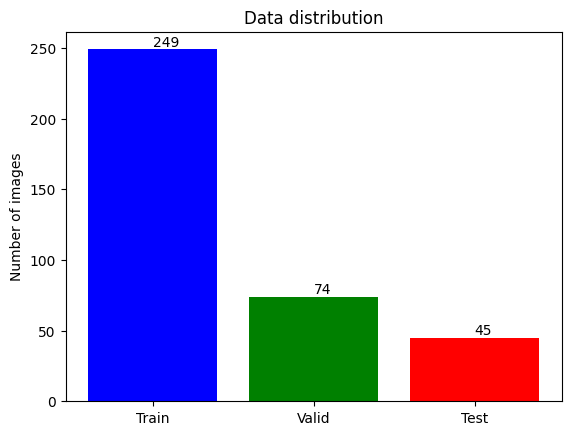

In [14]:
import matplotlib.pyplot as plt

def showDataLayout():
    # Data
    labels = ["Train", "Valid", "Test"]
    counts = [len(train_ids), len(val_ids), len(test_ids)]
    colors = ['blue', 'green', 'red']
    
    # Plot
    bars = plt.bar(labels, counts, align='center', color=colors)
    
    # Add data labels on top of bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom')  # va: vertical alignment

    # Add labels and title
    plt.ylabel('Number of images')
    plt.title('Data distribution')

    # Show plot
    plt.show()

# Call the function to display the plot
showDataLayout()


Epoch 1/40
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 689ms/step - accuracy: 0.9583 - dice_coef: 0.2516 - dice_coef_edema: 0.0412 - dice_coef_enhancing: 0.0117 - dice_coef_necrotic: 0.0138 - loss: 0.2409 - mean_io_u: 0.4811 - precision: 0.9378 - sensitivity: 0.9138 - specificity: 0.9946
Epoch 1: val_loss improved from inf to 0.06724, saving model to segnet_model.keras
249/249 ━━━━━━━━━━━━━━━━━━━━ 263s 900ms/step - accuracy: 0.9584 - dice_coef: 0.2517 - dice_coef_edema: 0.0413 - dice_coef_enhancing: 0.0117 - dice_coef_necrotic: 0.0139 - loss: 0.2405 - mean_io_u: 0.4811 - precision: 0.9379 - sensitivity: 0.9141 - specificity: 0.9946 - val_accuracy: 0.9839 - val_dice_coef: 0.2757 - val_dice_coef_edema: 0.0751 - val_dice_coef_enhancing: 0.0199 - val_dice_coef_necrotic: 0.0228 - val_loss: 0.0672 - val_mean_io_u: 0.5000 - val_precision: 0.9837 - val_sensitivity: 0.9838 - val_specificity: 0.9946 - learning_rate: 0.0010
Epoch 2/40
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 675ms/step - accuracy: 0.9833 - dice_coef:

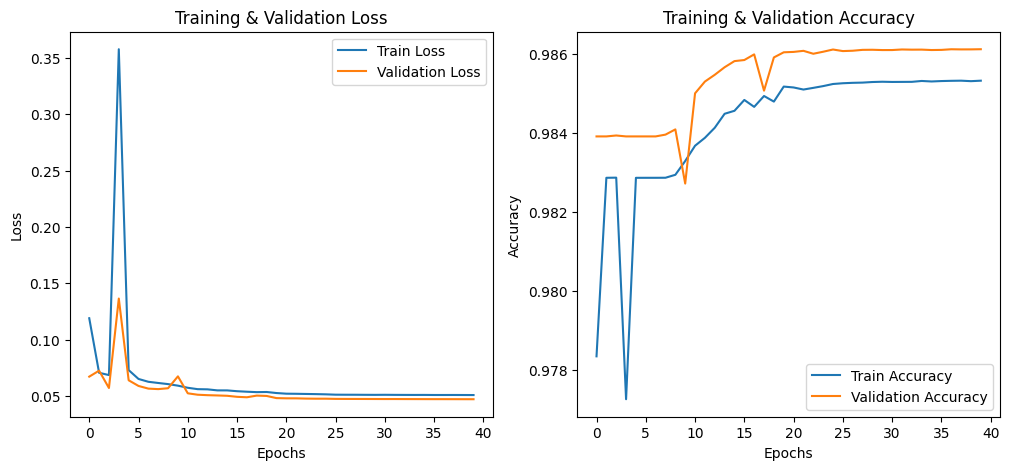

In [15]:
import matplotlib.pyplot as plt

# Define callbacks
csv_logger = CSVLogger('training.log')
checkpoint = ModelCheckpoint(
    'final_model.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    min_lr=0.000001,
    verbose=1
)

callbacks = [csv_logger, reduce_lr, checkpoint, early_stopping]

# Train the model
history = model.fit(
    training_generator,
    validation_data=valid_generator,
    epochs=40,
    callbacks=callbacks
)

# Evaluate the model
results = model.evaluate(test_generator)
print(f"Test results: {results}")

# Save the final model
model.save('final_model.keras')

# Print train and val accuracies and losses
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history.get('accuracy', history.history.get('categorical_accuracy', None))
val_acc = history.history.get('val_accuracy', history.history.get('val_categorical_accuracy', None))

if train_acc and val_acc:
    print(f"Final Training Accuracy: {train_acc[-1]:.4f}")
    print(f"Final Validation Accuracy: {val_acc[-1]:.4f}")

print(f"Final Training Loss: {train_loss[-1]:.4f}")
print(f"Final Validation Loss: {val_loss[-1]:.4f}")

# Plot training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Loss')

if train_acc and val_acc:
    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label='Train Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training & Validation Accuracy')

plt.show()


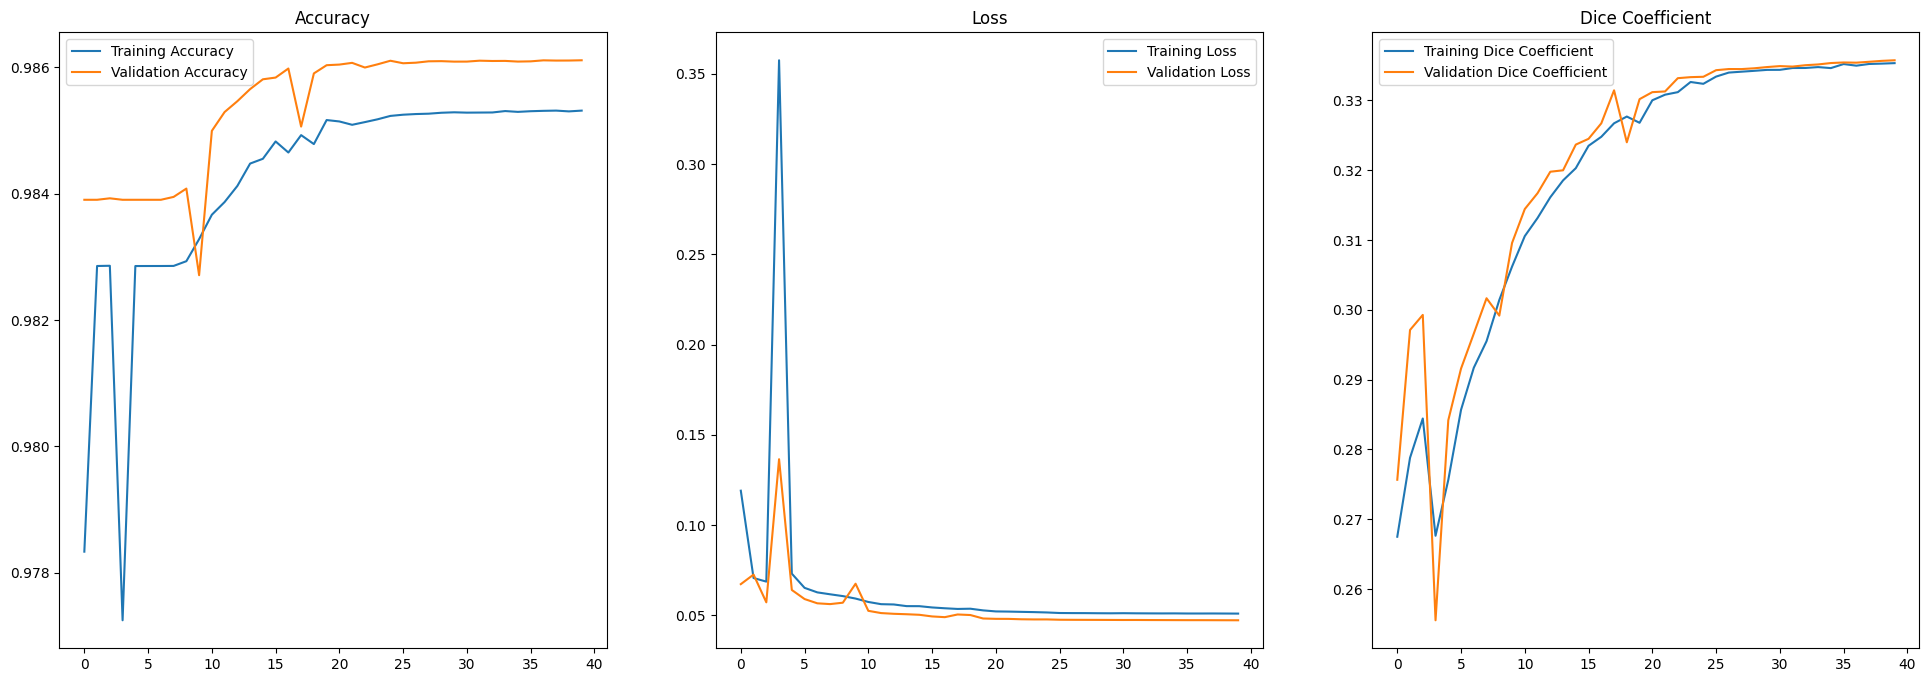

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

# Load the trained model with custom objects
model = keras.models.load_model(
    '/kaggle/working/segnet_model.keras',
    custom_objects={
        'accuracy': tf.keras.metrics.MeanIoU(num_classes=4),
        
        'precision': precision,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'dice_coef_necrotic': dice_coef_necrotic,
        'dice_coef_edema': dice_coef_edema,
        'dice_coef_enhancing': dice_coef_enhancing
    },
    compile=False
)

# Read the training log
history = pd.read_csv('/kaggle/working/training.log', sep=',', engine='python')
hist = history

# Extract metrics
acc = hist['accuracy']
val_acc = hist['val_accuracy']
epoch = range(len(acc))
loss = hist['loss']
val_loss = hist['val_loss']


# Plotting
f, ax = plt.subplots(1, 3, figsize=(24, 8))

# Training and Validation Accuracy
ax[0].plot(epoch, acc,  label='Training Accuracy')
ax[0].plot(epoch, val_acc,  label='Validation Accuracy')
ax[0].legend()
ax[0].set_title('Accuracy')

# Training and Validation Loss
ax[1].plot(epoch, loss,  label='Training Loss')
ax[1].plot(epoch, val_loss,  label='Validation Loss')
ax[1].legend()
ax[1].set_title('Loss')

train_dice = hist['dice_coef']  # Replace with actual column name for training Dice coefficient
val_dice = hist['val_dice_coef']

# Training and Validation Dice Coefficient
ax[2].plot(epoch, train_dice,  label='Training Dice Coefficient')
ax[2].plot(epoch, val_dice, label='Validation Dice Coefficient')
ax[2].legend()
ax[2].set_title('Dice Coefficient')

plt.show()


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 308ms/step


<Figure size 1800x5000 with 0 Axes>

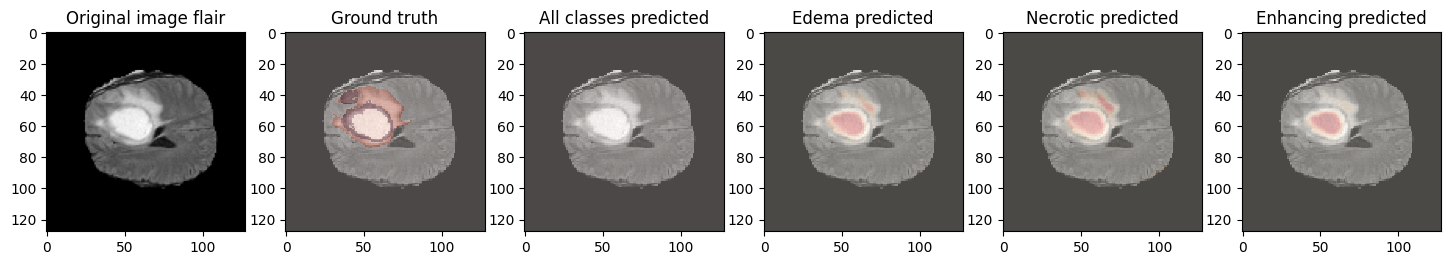

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


<Figure size 1800x5000 with 0 Axes>

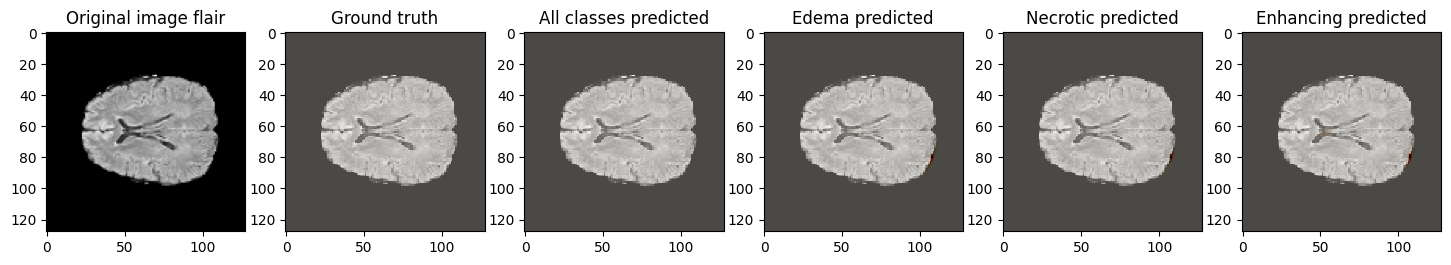

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


<Figure size 1800x5000 with 0 Axes>

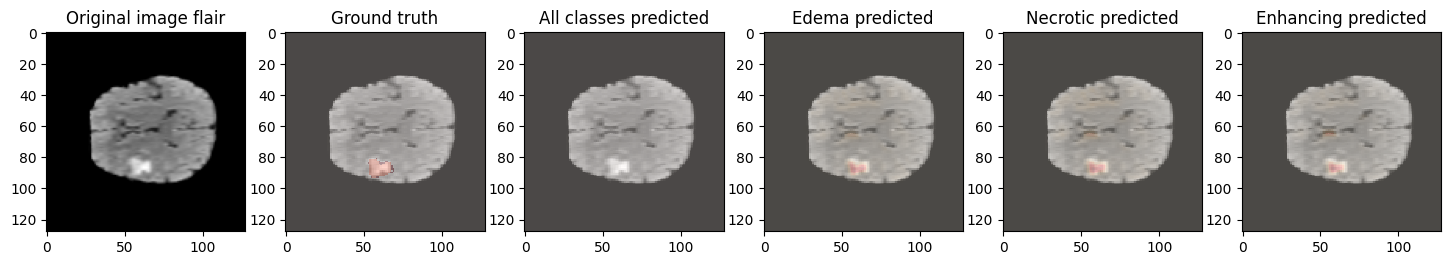

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


<Figure size 1800x5000 with 0 Axes>

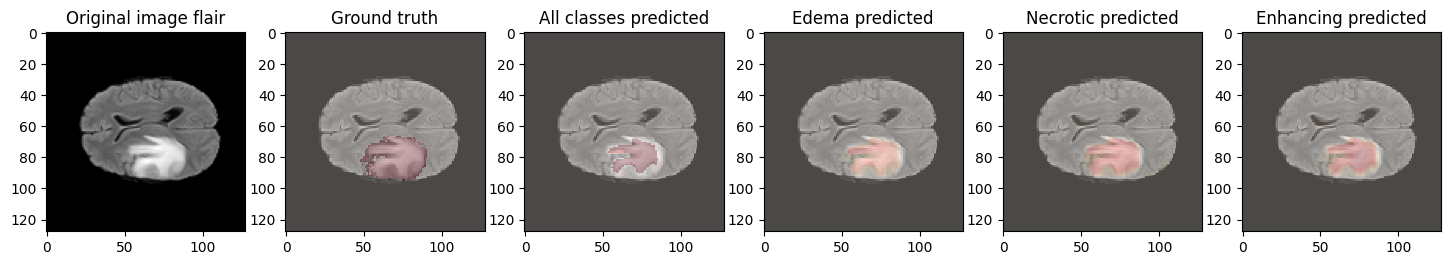

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


<Figure size 1800x5000 with 0 Axes>

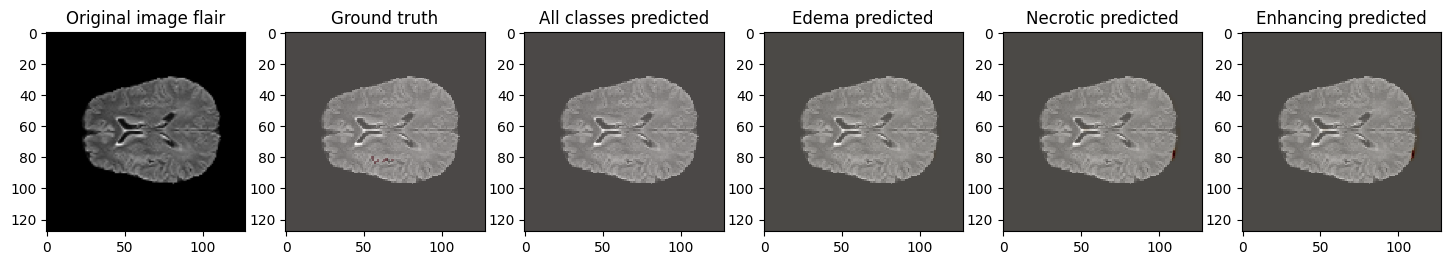

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


<Figure size 1800x5000 with 0 Axes>

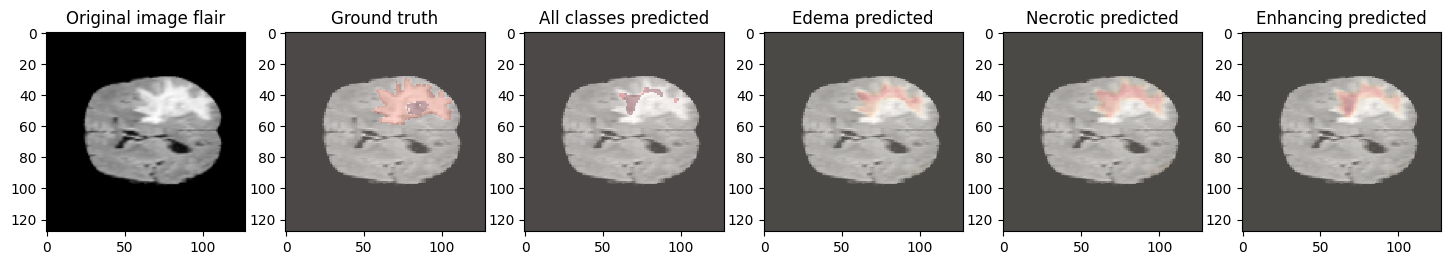

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


<Figure size 1800x5000 with 0 Axes>

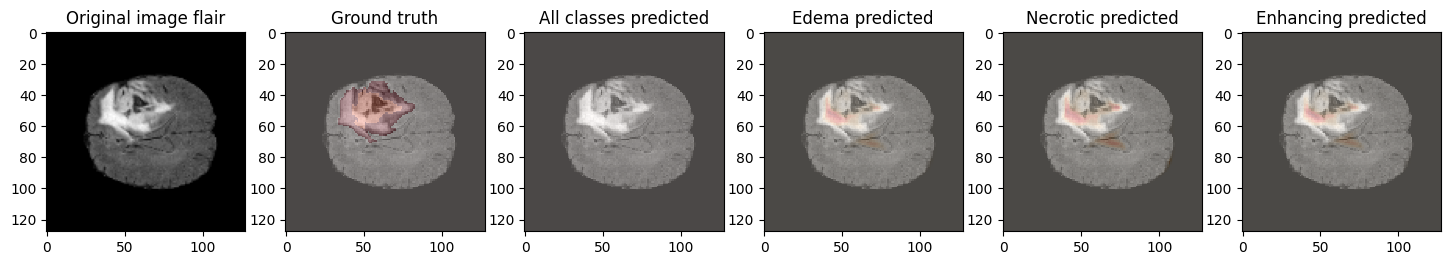

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


<Figure size 1800x5000 with 0 Axes>

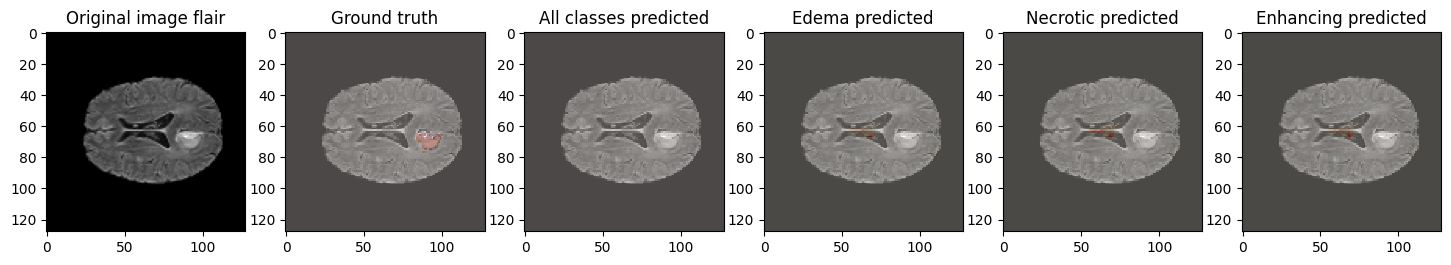

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


<Figure size 1800x5000 with 0 Axes>

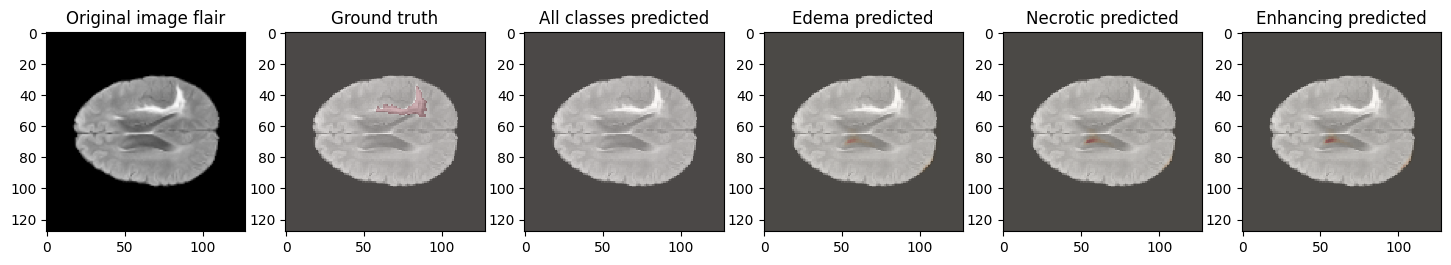

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


<Figure size 1800x5000 with 0 Axes>

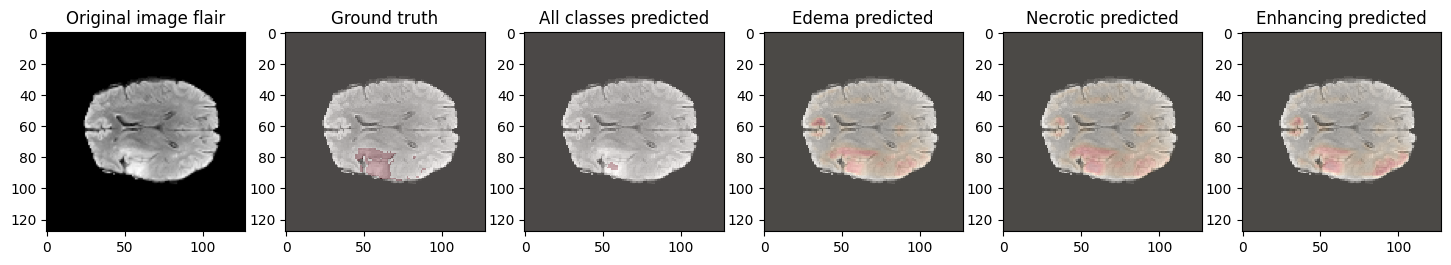

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


<Figure size 1800x5000 with 0 Axes>

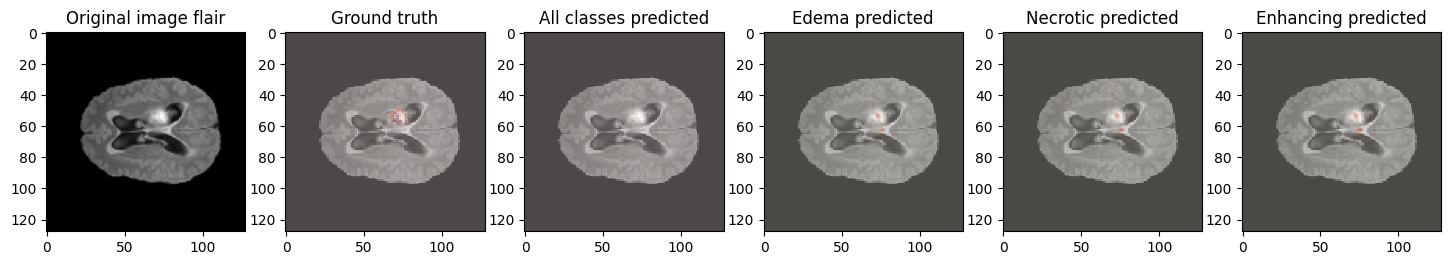

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


<Figure size 1800x5000 with 0 Axes>

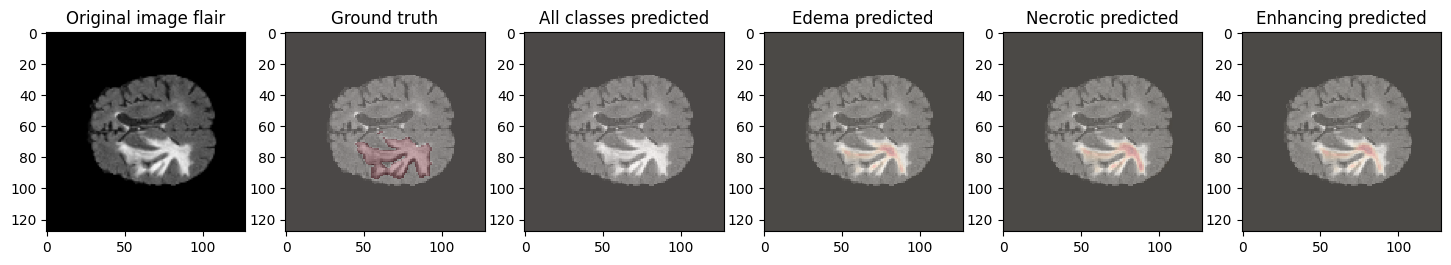

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


<Figure size 1800x5000 with 0 Axes>

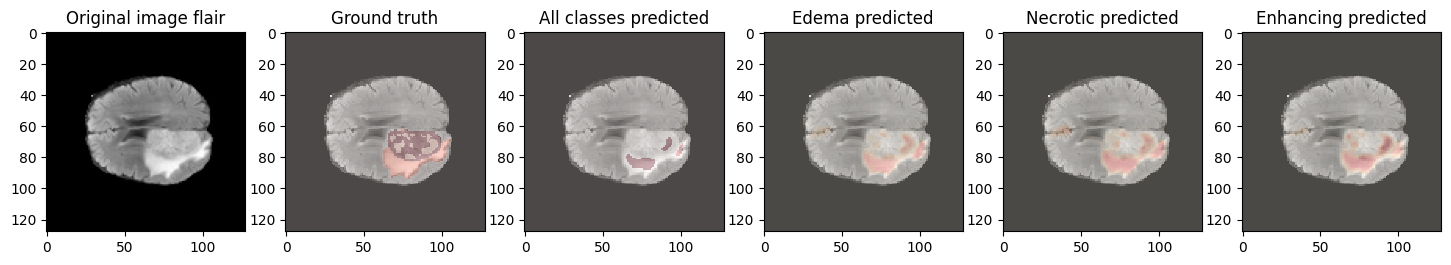

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


<Figure size 1800x5000 with 0 Axes>

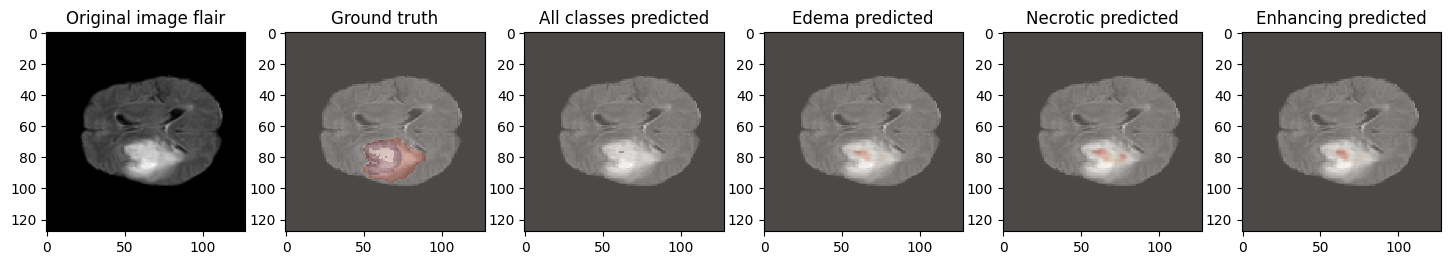

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


<Figure size 1800x5000 with 0 Axes>

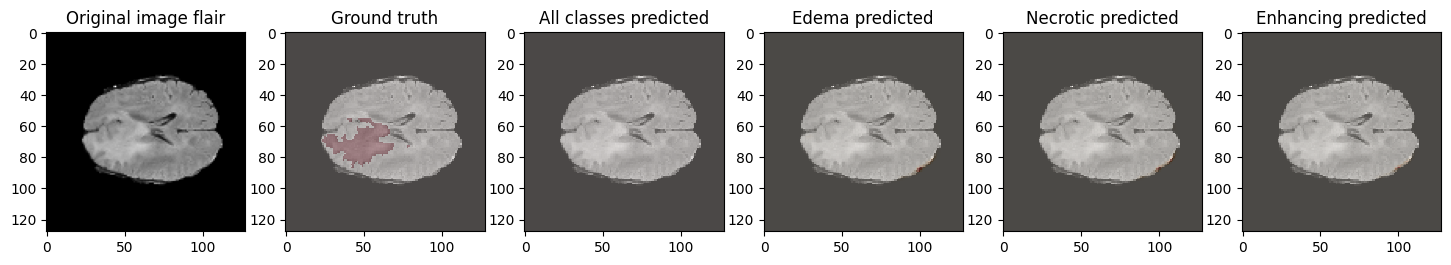

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


<Figure size 1800x5000 with 0 Axes>

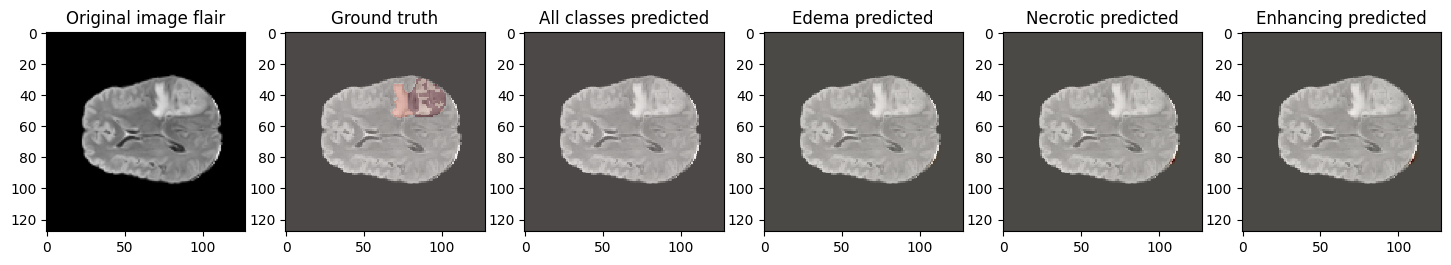

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


<Figure size 1800x5000 with 0 Axes>

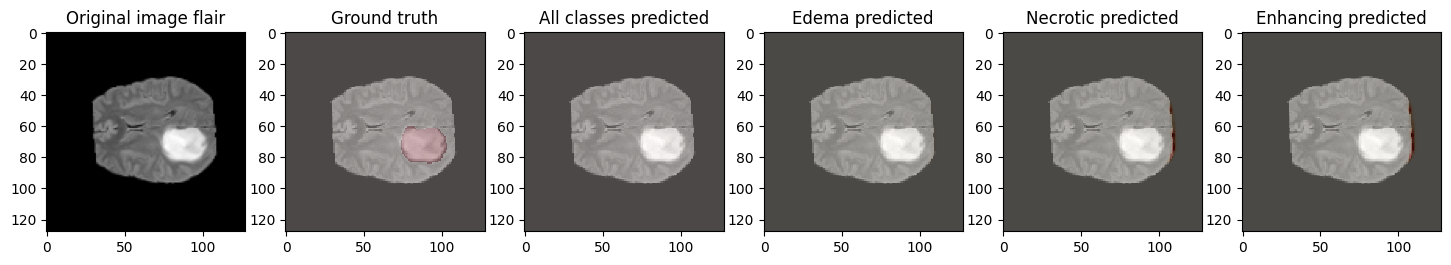

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


<Figure size 1800x5000 with 0 Axes>

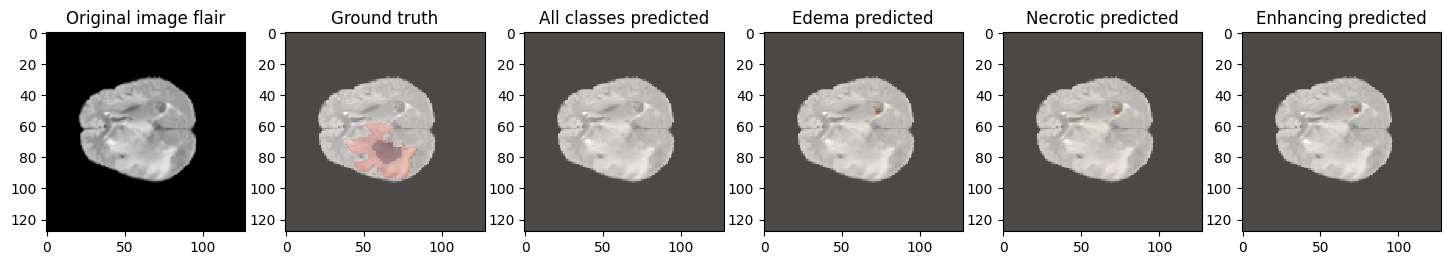

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


<Figure size 1800x5000 with 0 Axes>

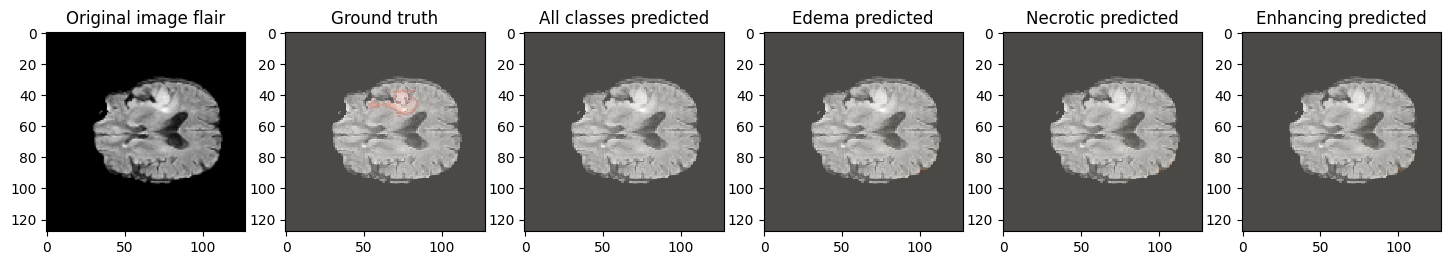

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


<Figure size 1800x5000 with 0 Axes>

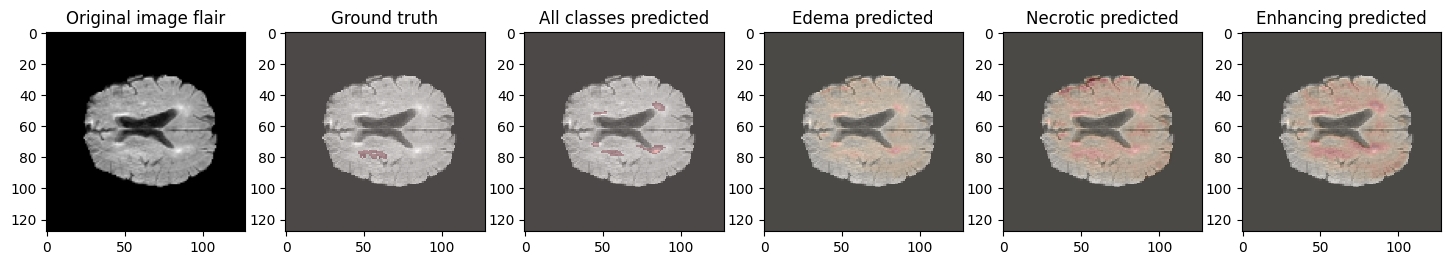

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


<Figure size 1800x5000 with 0 Axes>

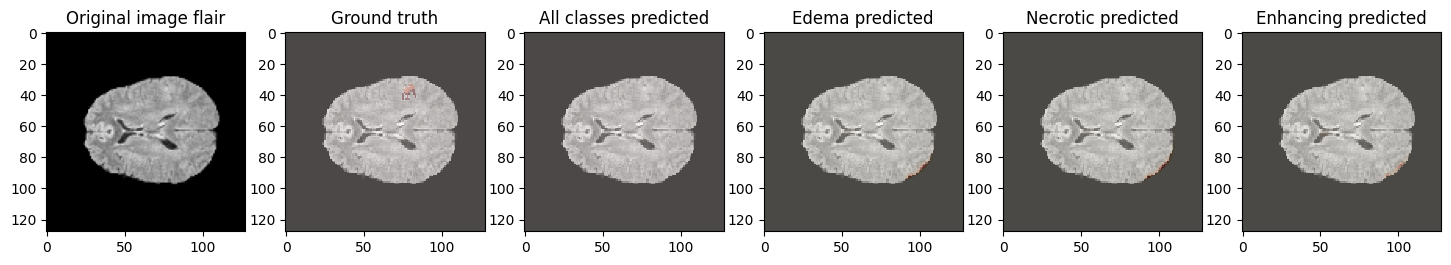

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


<Figure size 1800x5000 with 0 Axes>

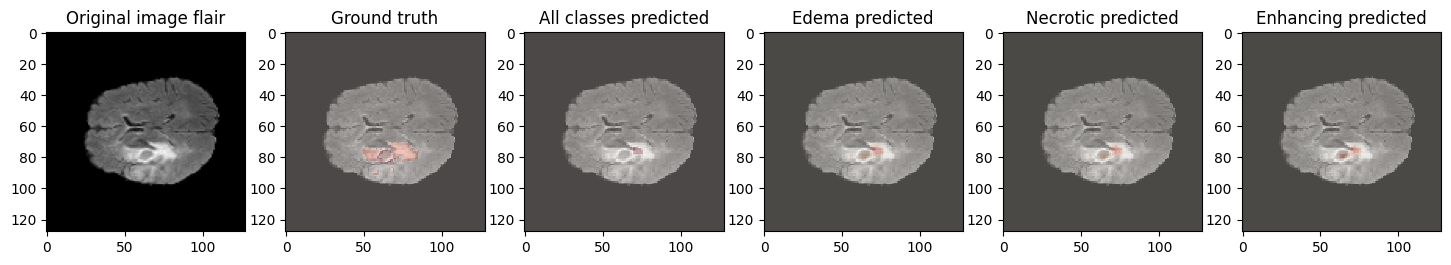

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


<Figure size 1800x5000 with 0 Axes>

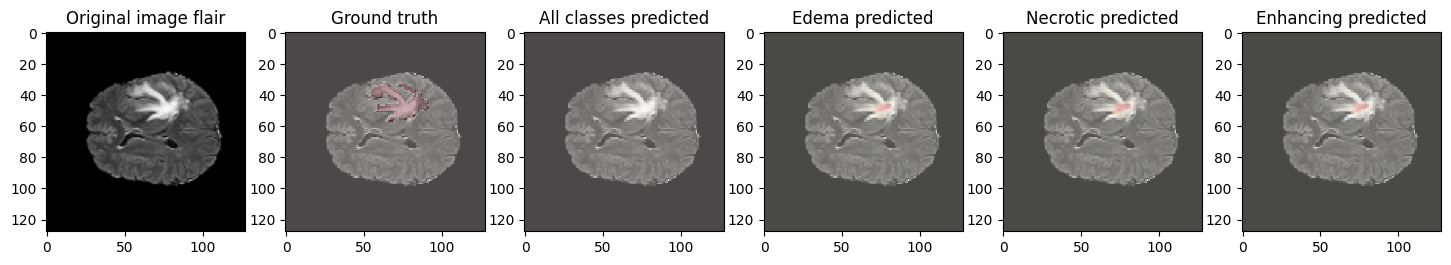

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


<Figure size 1800x5000 with 0 Axes>

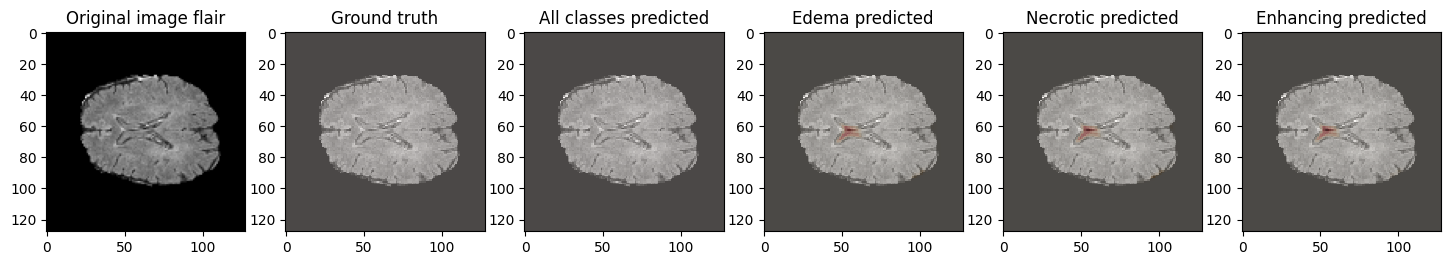

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


<Figure size 1800x5000 with 0 Axes>

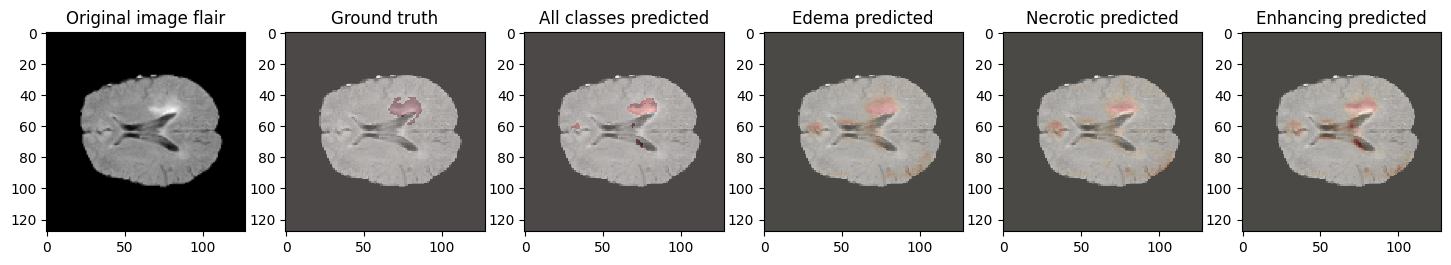

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


<Figure size 1800x5000 with 0 Axes>

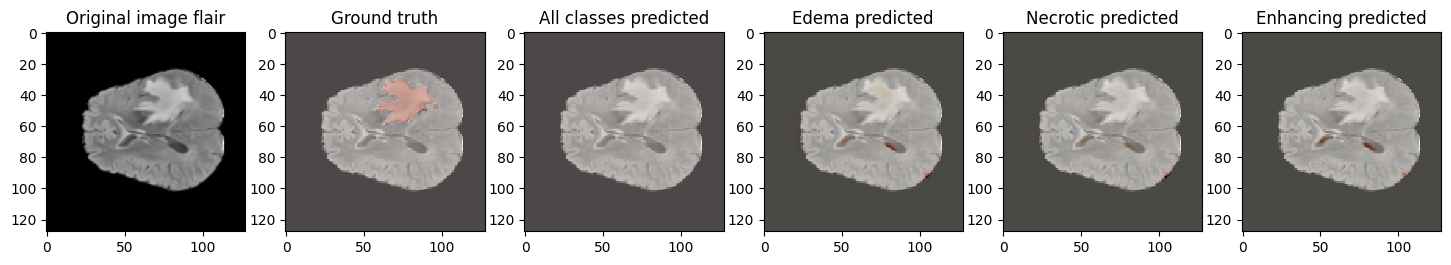

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


<Figure size 1800x5000 with 0 Axes>

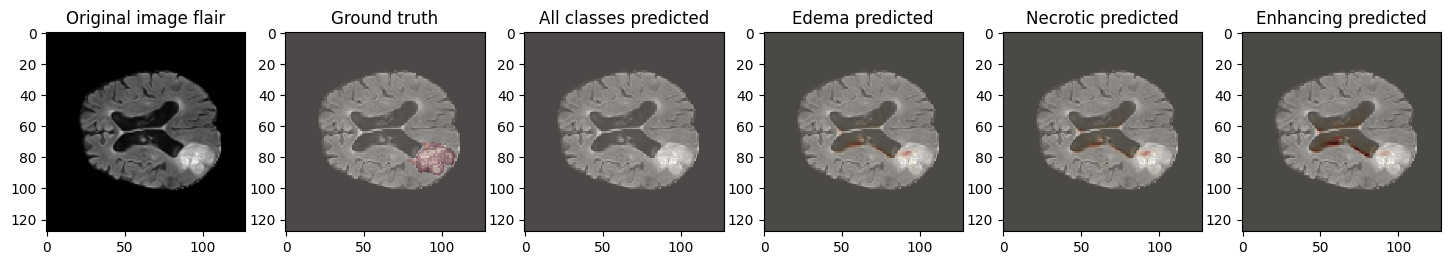

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


<Figure size 1800x5000 with 0 Axes>

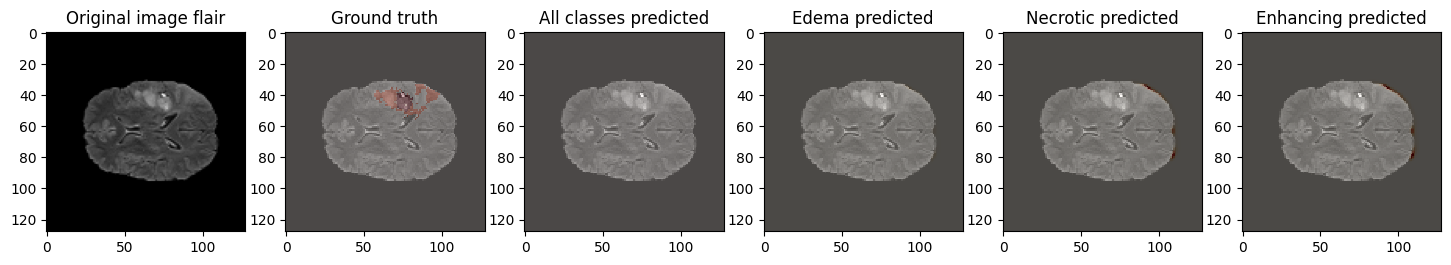

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


<Figure size 1800x5000 with 0 Axes>

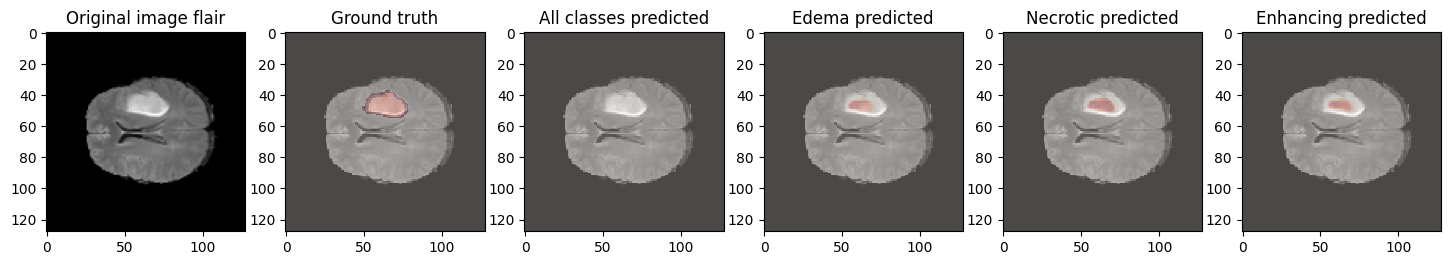

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


<Figure size 1800x5000 with 0 Axes>

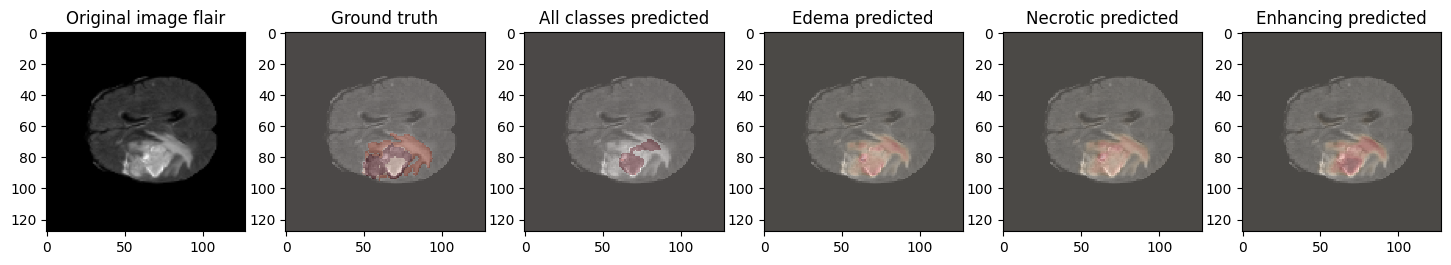

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


<Figure size 1800x5000 with 0 Axes>

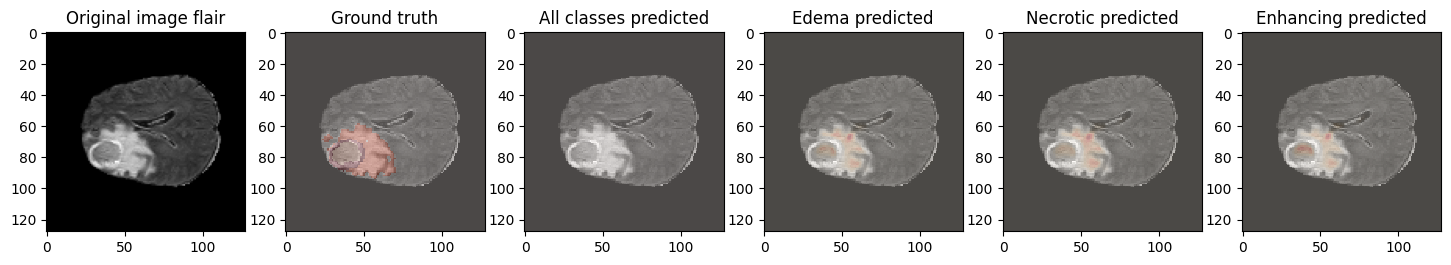

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


<Figure size 1800x5000 with 0 Axes>

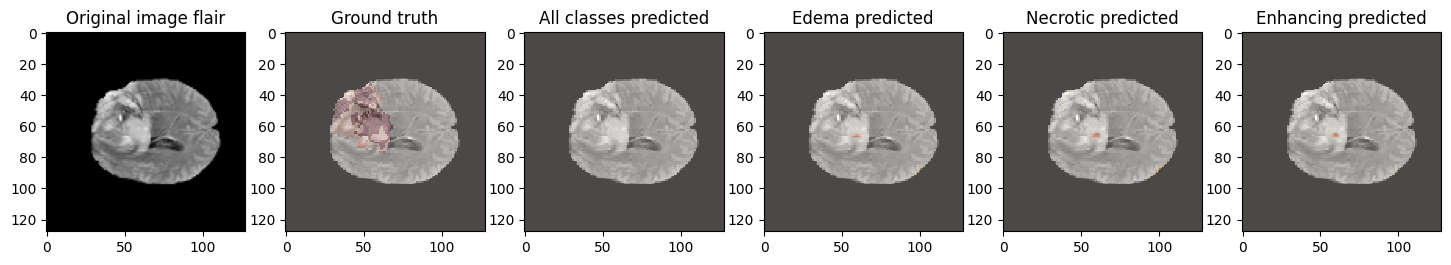

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


<Figure size 1800x5000 with 0 Axes>

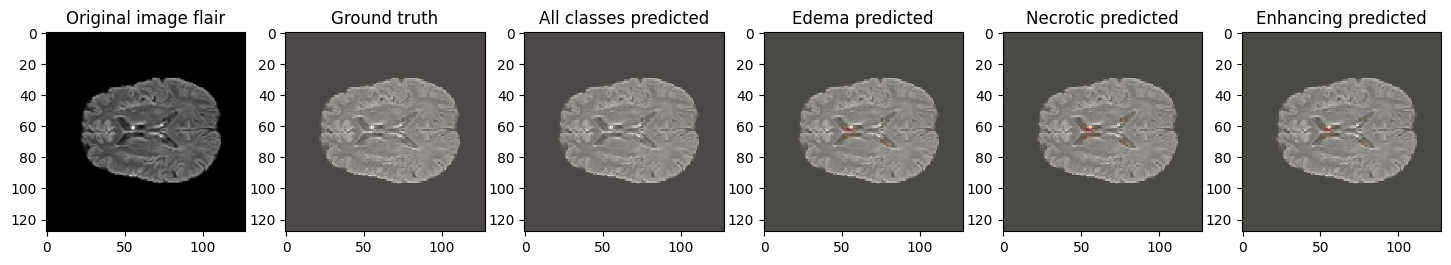

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


<Figure size 1800x5000 with 0 Axes>

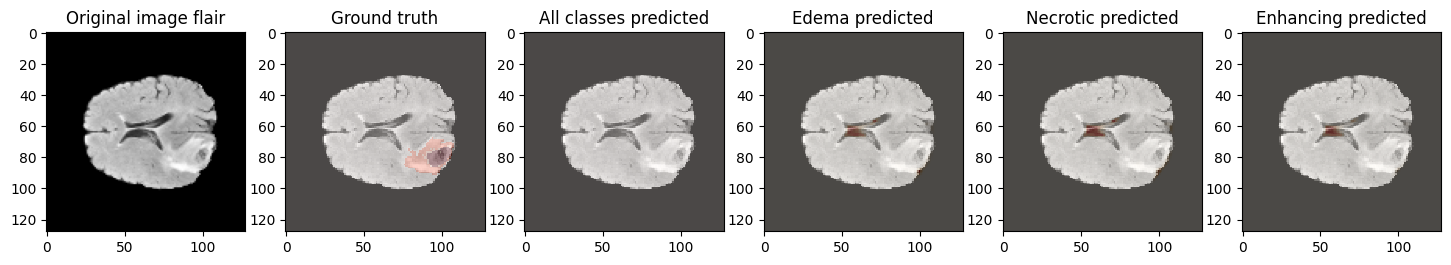

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


<Figure size 1800x5000 with 0 Axes>

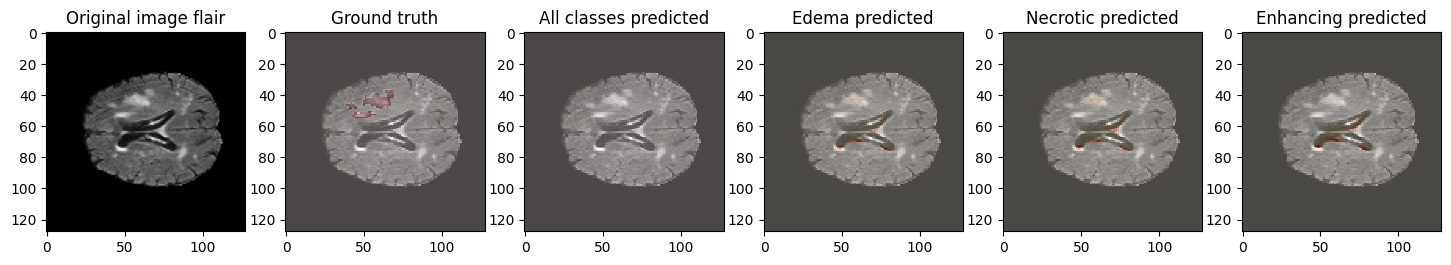

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


<Figure size 1800x5000 with 0 Axes>

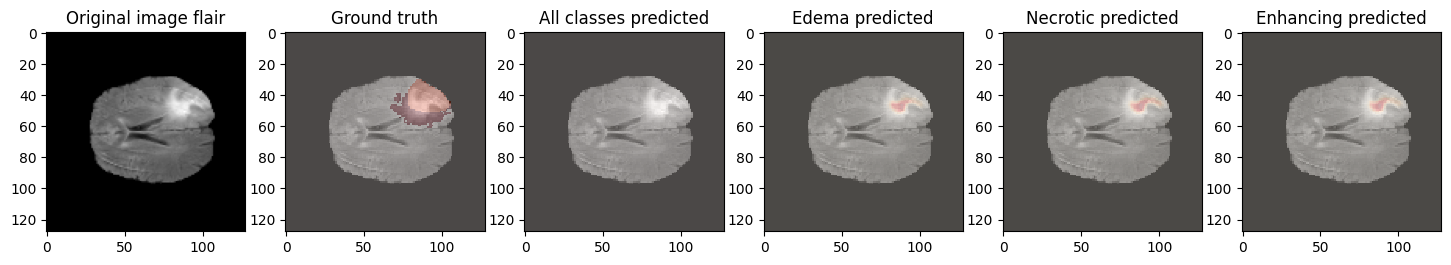

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


<Figure size 1800x5000 with 0 Axes>

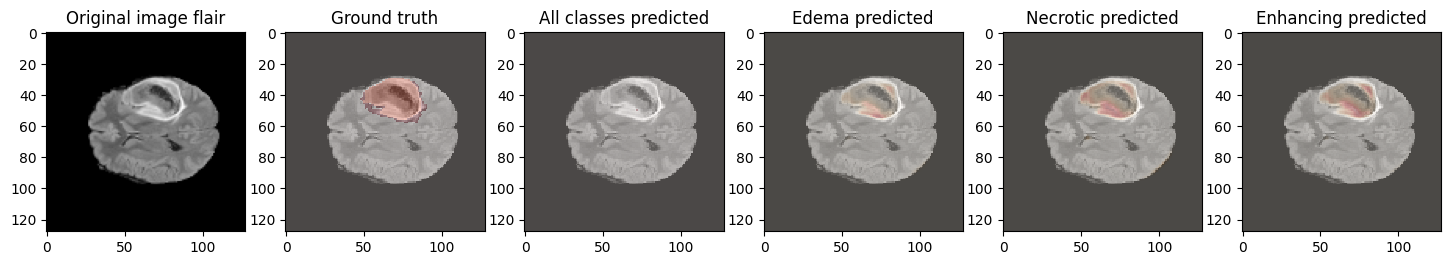

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


<Figure size 1800x5000 with 0 Axes>

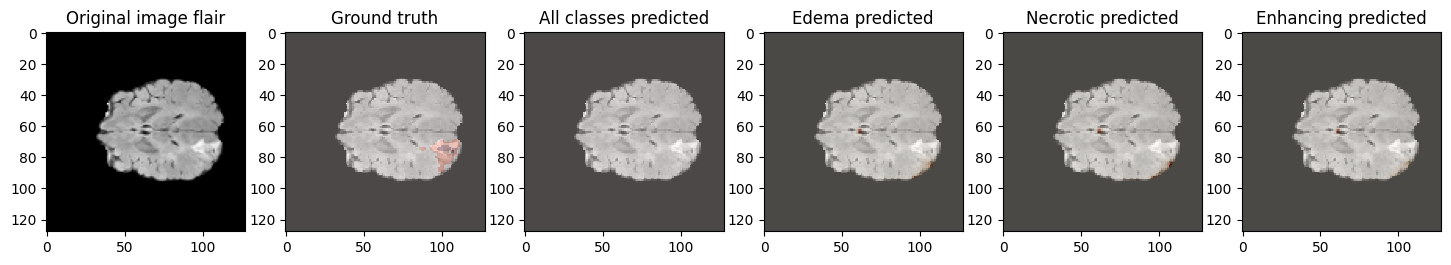

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


<Figure size 1800x5000 with 0 Axes>

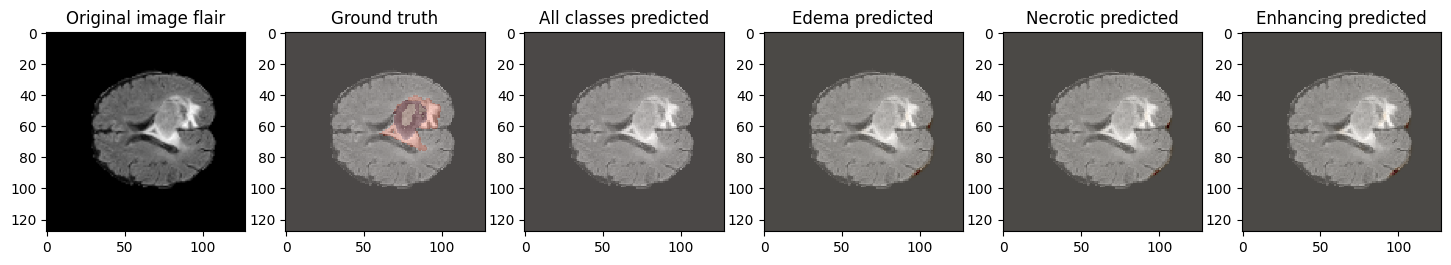

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


<Figure size 1800x5000 with 0 Axes>

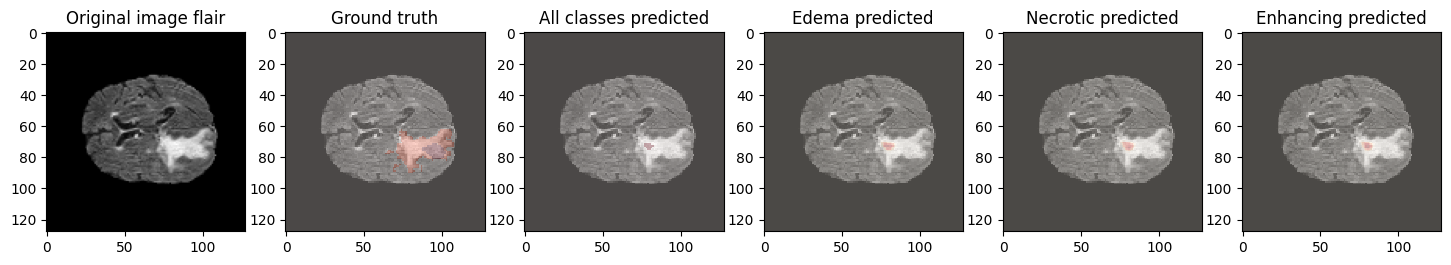

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


<Figure size 1800x5000 with 0 Axes>

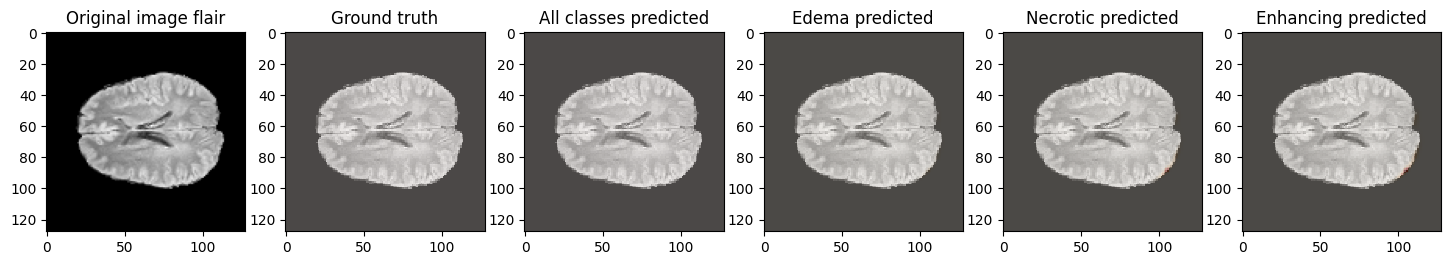

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


<Figure size 1800x5000 with 0 Axes>

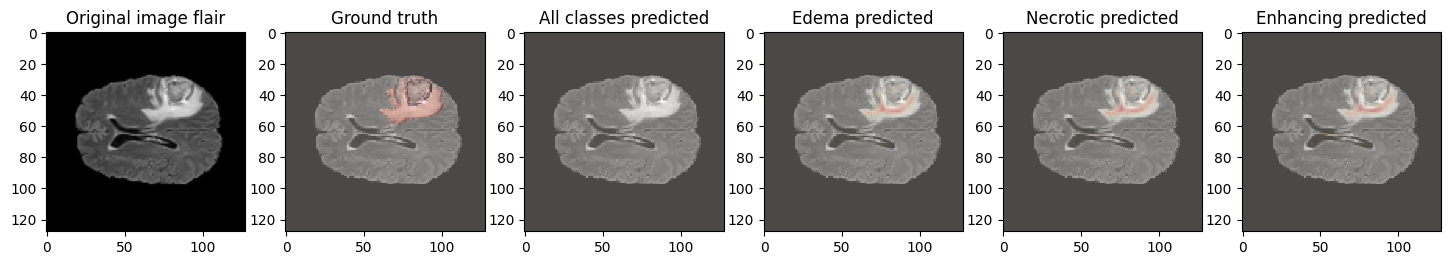

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


<Figure size 1800x5000 with 0 Axes>

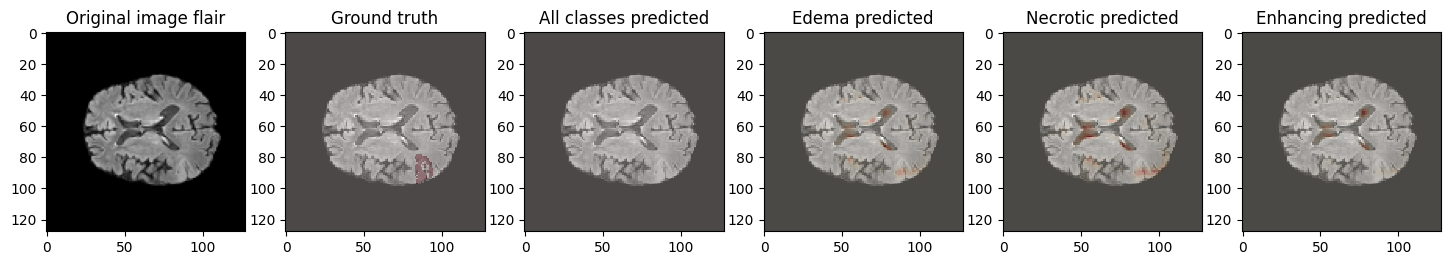

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


<Figure size 1800x5000 with 0 Axes>

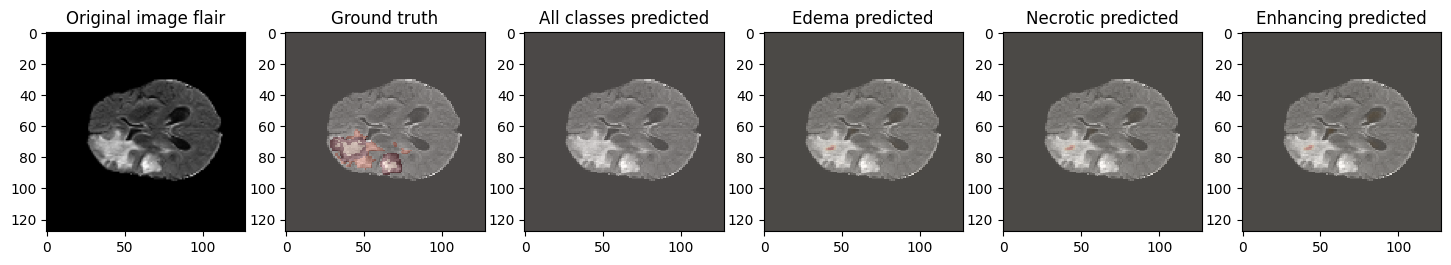

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


<Figure size 1800x5000 with 0 Axes>

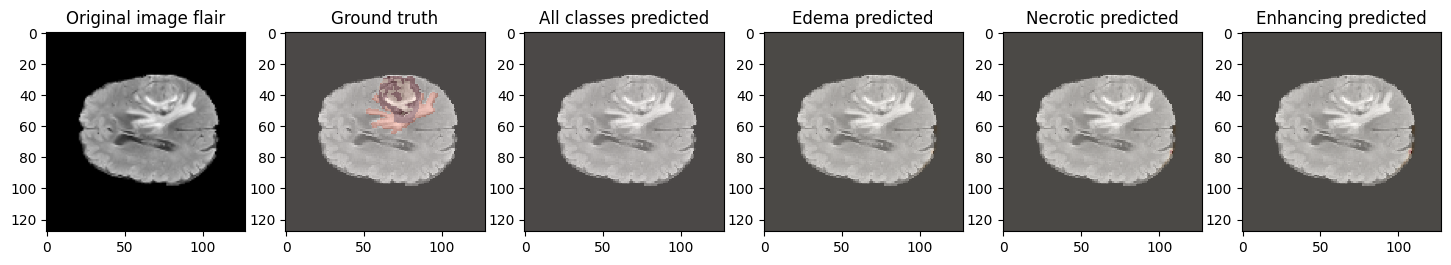

In [35]:
# Define the segment classes you are working with
SEGMENT_CLASSES = ["Background", "Necrotic", "Edema", "Enhancing"]

def predictByPath(case_path, case):
    # Prepare input array (4 channels for T1, T1c, T2, FLAIR)
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 4))  # Adjusted for 4 channels

    # Load each modality and store in the appropriate channel
    modalities = ['flair', 't1', 't1ce', 't2']  # Define the required modalities
    for idx, modality in enumerate(modalities):
        vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_{modality}.nii')
        modality_data = nib.load(vol_path).get_fdata()

        # Resize and assign each slice to the corresponding channel
        for j in range(VOLUME_SLICES):
            X[j, :, :, idx] = cv2.resize(modality_data[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

    # Normalize the input
    X_normalized = X / np.max(X)

    # Predict using the loaded SegNet model
    return model.predict(X_normalized, verbose=1)

def showPredictsById(case, start_slice=60):
    path = f"../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
    
    # Load ground truth and original flair image for comparison
    gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
    origImage = nib.load(os.path.join(path, f'BraTS20_Training_{case}_flair.nii')).get_fdata()
    
    # Get predictions
    p = predictByPath(path, case)

    # Predicted segmentation classes
    core = p[:, :, :, 1]       # Necrotic core
    edema = p[:, :, :, 2]      # Edema
    enhancing = p[:, :, :, 3]  # Enhancing tumor

    plt.figure(figsize=(18, 50))
    f, axarr = plt.subplots(1, 6, figsize=(18, 50))

    # Show flair image and add brain background for each slice
    for i in range(6):
        axarr[i].imshow(cv2.resize(origImage[:, :, start_slice + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray", interpolation='none')

    # Flair image
    axarr[0].imshow(cv2.resize(origImage[:, :, start_slice + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    axarr[0].title.set_text('Original image flair')

    # Ground truth segmentation
    curr_gt = cv2.resize(gt[:, :, start_slice + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
    axarr[1].imshow(curr_gt, cmap="Reds", interpolation='none', alpha=0.3)
    axarr[1].title.set_text('Ground truth')

    # Predicted segmentation (all classes combined)
    axarr[2].imshow(np.argmax(p[start_slice, :, :, :], axis=-1), cmap="Reds", interpolation='none', alpha=0.3)
    axarr[2].title.set_text('All classes predicted')

    # Predicted Edema class
    axarr[3].imshow(edema[start_slice, :, :], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[3].title.set_text(f'{SEGMENT_CLASSES[2]} predicted')

    # Predicted Necrotic core class
    axarr[4].imshow(core[start_slice, :, :], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[4].title.set_text(f'{SEGMENT_CLASSES[1]} predicted')

    # Predicted Enhancing tumor class
    axarr[5].imshow(enhancing[start_slice, :, :], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[5].title.set_text(f'{SEGMENT_CLASSES[3]} predicted')

    plt.show()

# Example usage for test cases
for case in test_ids[:45]:  
    showPredictsById(case=case[-3:])
